In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

100% 2.70G/2.70G [00:27<00:00, 64.2MB/s]
100% 2.70G/2.70G [00:27<00:00, 104MB/s] 


In [ ]:
!ls

 base.model		 kaggle.json
 blood-cells.zip	 logs
 eurusd_hour.csv	 new-plant-diseases-dataset.zip
 eurusd_minute.csv	 nsfw-image-classification.zip
 eurusd_news.csv	'Old data'
 fruit-recognition.zip	 training_csv.log
 fruits.zip


In [ ]:
import zipfile
local_zip = 'new-plant-diseases-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/dataset')
zip_ref.close()

In [ ]:
base_dir= '/tmp/dataset/'
os.listdir(base_dir)

['test',
 'new plant diseases dataset(augmented)',
 'New Plant Diseases Dataset(Augmented)']

In [ ]:
train_dir = '/tmp/dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
val_dir = '/tmp/dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dir = '/tmp/dataset/test/test'

In [ ]:
# for vizualisation loss and accuracy
import matplotlib.pyplot as plt

def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    fill_mode='nearest',
                    shear_range = 0.2,
                    zoom_range=0.2) # dataset already have 80/20 ratio of train and val set

train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(224, 224), 
        batch_size=128,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = train_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=128,
        class_mode='categorical',
        shuffle=False)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152V2
model = tf.keras.models.Sequential([
    ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3))),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(38, activation='softmax')  
])
model.layers[0].trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 4096)              411045888 
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92):
      print("\nAccuration's reached > 92%!")
      self.model.stop_training = True
accuration_check = myCallback()

best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=40,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [ ]:
train_qty = train_generator.samples
valid_qty = validation_generator.samples

In [ ]:
histori = model.fit(
      train_generator,
      steps_per_epoch=train_qty//128,  
      epochs=20,
      validation_data=validation_generator, 
      validation_steps=valid_qty//128,  
      verbose=1,
      callbacks=[callbacks,accuration_check])

Epoch 1/20
  1/549 [..............................] - ETA: 0s - loss: 4.6296 - accuracy: 0.0312WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
549/549 [==============================] - ETA: 0s - loss: 0.6986 - accuracy: 0.7858
Epoch 00001: val_loss improved from inf to 0.35267, saving model to ./base.model
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./base.model/assets
549/549 [==============================] - 1957s 4s/step - loss: 0.6986 - accuracy: 0.7858 - val_loss: 0.3527 - val_accuracy: 0.8866
Epoch 2/20
549/549 [===================

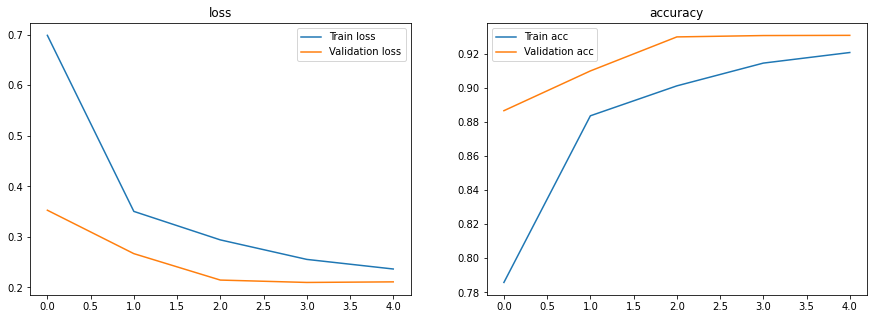

In [ ]:
show_final_history(histori)
model_json = model.to_json()

In [ ]:
# Convertion model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpu_3nm735/assets


In [ ]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
import pickle
list_1 = ['1', '4', 'c', 'd']
with open('my_model.h5', 'wb') as f1:
   pickle.dump(list_1, f1)

In [ ]:
import pickle
pickle_off = open ("my_model.h5", "rb")
emp = pickle.load(pickle_off)
print(emp)

['1', '4', 'c', 'd']


In [ ]:
model.save_weights('./checkpoints/my_checkpoint')

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
model.save('my_model.h5') 